In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

import numpy as np, pandas as pd
from pandas import DataFrame, Series, DatetimeIndex
from pandas.api.types import CategoricalDtype

# import lifelines
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

import patsy

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#For plots
% matplotlib inline
import matplotlib.pyplot as plt

from itertools import combinations

In [2]:
pd.options.display.max_rows = 999

# set path
path = '~/Downloads/'

# The file downloaded from Funding Circle has a default name
fn = 'loanbook.csv'
pathfn = path + fn

# Load CSV, first row is header, columns 17 and 18 contains dates in international day first format, first column (loan id) will be index
loanbook = pd.read_csv(pathfn, header=0, parse_dates=[17, 18], dayfirst=True)

# Add column for current loan duration
loanbook['T'] = loanbook['term'] - loanbook['payments_remaining']

# Add column for default Events (deaths)
loanbook['E'] = loanbook.apply( lambda x: 1 if x['status'] == 'loan: defaulted' else 0, axis = 1).astype('int')  #Default observed

# Extract year of orgination
loanbook['year_originated'] = DatetimeIndex(loanbook['loan_accepted_date']).year

# Add column for Years incorporated
loanbook['years_incorporated'] = loanbook['year_originated'] - loanbook['year_incorporated']
loanbook['years_incorporated'] = loanbook['years_incorporated'].astype(str)

# Add binary column for loan parts
loanbook['loan_parts'] = loanbook.apply( lambda x: 1 if x['num_loan_parts'] > 1 else 0, axis=1).astype('int')  #More than one loan part

# Add binary column for whole loan
loanbook['whole_loan'] = loanbook.apply( lambda x: 1 if x['whole_loan'] == 'WL' else 0, axis=1).astype('int')  #Whole loan funded

# Replace blanks with 0
loanbook['loan_guaranteed'].fillna(0, inplace=True)

# Set logical order to be different from lexical order for credit bands by defining it as a categorical data type so we can sort later 
ordered_band = CategoricalDtype(categories = ["A+ (Very low risk)", "A (Low risk)", "B (Below average risk)", "C (Average risk)", "D", "E"], ordered=True)
loanbook['credit_band'] = loanbook['credit_band'].astype(ordered_band)

# Print size of dataframe (rows, columns)
print(loanbook.shape)

# View top rows
loanbook.head()  

(50099, 30)


,id,status,credit_band,loan_purpose,sector,business_type_name,region_name,loan_amount,recoveries,interest_rate,...,related_auctions,repayment_type,loan_guaranteed,year_incorporated,security_taken,T,E,year_originated,years_incorporated,loan_parts
0,4,loan: repaid,A (Low risk),Asset purchase,Wholesale,Limited Company,East Anglia,25000.0,0.00,8.11,...,NaN,Amortising,1.0,1992.0,No asset security,36,0,2010,18.0,1
1,6,loan: repaid,A (Low risk),Expansion/growth Capital,Manufacturing and Engineering,Limited Company,South East,50000.0,0.00,10.57,...,"44820, 1079",Amortising,1.0,1967.0,No asset security,36,0,2010,43.0,1
2,8,loan: repaid,A (Low risk),Working capital,Leisure & Hospitality,Limited Company,South West,15000.0,0.00,7.99,...,NaN,Amortising,1.0,1968.0,No asset security,36,0,2010,42.0,1
3,9,loan: repaid,B (Below average risk),Asset purchase,Other,Limited Company,South West,12000.0,0.00,8.35,...,27240,Amortising,1.0,2005.0,No asset security,36,0,2010,5.0,1
4,10,loan: defaulted,B (Below average risk),Expansion/growth Capital,Retail,Limited Company,London,30000.0,2.38,9.06,...,NaN,Amortising,0.0,1990.0,No asset security,19,1,2010,20.0,1


In [3]:
# Create series with loan purpose counts
purposes = Series(loanbook['loan_purpose'].value_counts())
# Create list of top purposes only (>99 observations)
top_purposes = list(purposes[purposes > 99].index)
top_purposes # Output

['Expansion/growth',
 'Working capital',
 'Expansion/growth Capital',
 'Asset finance',
 'Expansion/growth capital',
 'Refinancing a loan',
 'Property development',
 'Other',
 'Tax payment',
 'Working Capital',
 'Expansion/Growth',
 'Asset purchase',
 'Residential property development',
 'Expansion And Growth',
 'Asset Purchase']

In [4]:
# Create list of purposes we want to match to, removing duplicates
choices = ['Working capital','Expansion/growth','Expansion/growth capital','Other','Asset purchase','Property development','Asset finance','Refinancing a loan','Tax payment']

# Create list of unique purposes
unique_purpose = list(loanbook['loan_purpose'].unique())

unique_purposes = [x for x in unique_purpose if str(x) != 'nan']

# Create empty list to hold unique to top purposes mappings
purpose_list = []

# Loop through unique purposes and match to highest scoring top purpose using Quick Ratio (or WRatio)
for unique in unique_purposes:
    top_purpose = process.extract(unique, choices, scorer=fuzz.QRatio, limit=1)
    purpose_list.append([(unique,) + tp for tp in top_purpose])

# Create DataFrame from flattened list of mappings
df_purpose = DataFrame([item for sublist in purpose_list for item in sublist], columns=['loan_purpose','top_purpose','Score'])

# Assign any scores < 50 to "Other" top purpose and drop score column
df_purpose.loc[df_purpose.Score < 50, 'top_purpose'] = 'Other'
df_purpose.drop('Score', axis=1, inplace=True)

# Merge Top purpose on to loanbook
loanbook = pd.merge(loanbook, df_purpose, how='inner', on='loan_purpose')


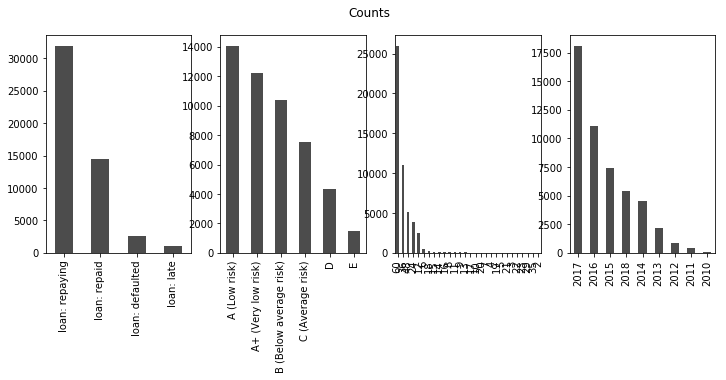

In [5]:
# Exploratory counts and plots

# Create list of variables we are interested in profiling
dimensions = ['status','credit_band','term','year_originated']

#Define plot object
fig = plt.figure(figsize=(12,4))
fig.suptitle("Counts")

# Loop through variable list producing counts and plots
for i, dimension in enumerate(dimensions):
    counts = loanbook[dimension].value_counts()
    # print(counts)
    axis = fig.add_subplot(1,4,i+1)
    counts.plot(kind='bar', ax=axis, color='k', alpha=0.7)

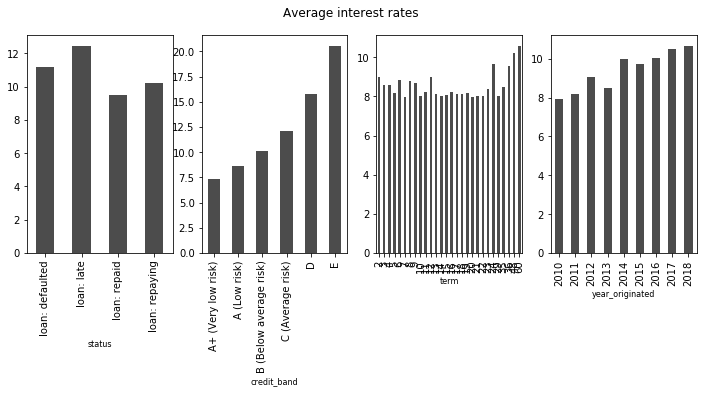

In [6]:
# Explaratory stats and plots of interest rates

# Create list of variables we are interested in profiling
dimensions = ['status','credit_band','term','year_originated']

# Define plot object
fig1 = plt.figure(figsize = (12,4))
fig1.suptitle("Average interest rates")

# function to return mean values 
def summary(dimension):
    grouped = loanbook.groupby(dimension)
    grouped_val = grouped['interest_rate']
    table = grouped_val.agg('mean')
    plotvalue = grouped_val.agg('mean')
    return table, plotvalue

# Loop through variable list and call summary function
for i, dimension in enumerate(dimensions):
    table, plotvalue = summary(dimension)
    # print(table)
    axis = fig1.add_subplot(1,4,i+1)
    plotvalue.plot(kind = 'bar', ax = axis, color = 'k', alpha = 0.7)
    axis.set_xlabel(dimension,fontsize = 8)

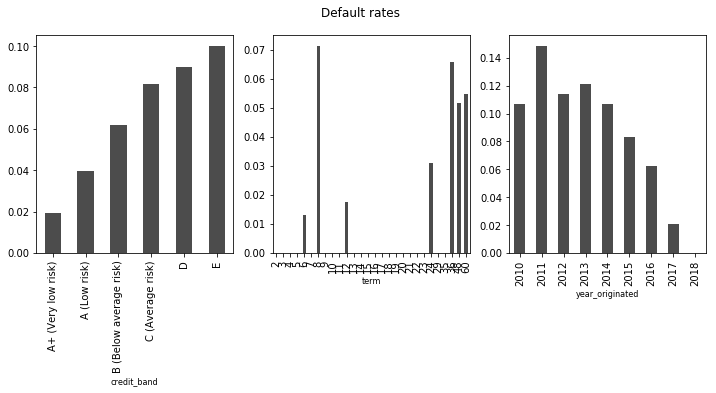

In [7]:
# Explaratory stats and plots of default rates

# Create list of variables we are interested in profiling
dimensions = ['credit_band','term','year_originated']

# Define plot object
fig2 = plt.figure(figsize=(12,4))
fig2.suptitle("Default rates")

# function to return mean default rates, counts and plots 
def summary(dimension):
    grouped = loanbook.groupby(dimension)
    grouped_D = grouped['E']
    table = grouped_D.agg({'mean','count'})
    plotvalue = grouped_D.agg('mean')
    return table, plotvalue

# Loop through variable list and call summary function
for i, dimension in enumerate(dimensions):
    table, plotvalue = summary(dimension)
    # print(table)
    axis = fig2.add_subplot(1,3,i+1)
    plotvalue.plot(kind = 'bar', ax = axis, color = 'k', alpha = 0.7)
    axis.set_xlabel(dimension,fontsize =8)

In [8]:
# Create credit band by origination year pivot table of default rates 
loanbook.pivot_table(values=['E'], index='credit_band', columns = 'year_originated')

E                                          \
year_originated             2010      2011      2012      2013      2014   
credit_band                                                                
A (Low risk)            0.052632  0.049505  0.081081  0.034091  0.042641   
B (Below average risk)  0.060606  0.160839  0.119048  0.091884  0.077276   
A+ (Very low risk)      0.217391  0.207547  0.113074  0.135185  0.121708   
C (Average risk)             NaN  0.095238  0.120155  0.129969  0.150857   
D                            NaN       NaN       NaN  0.256579  0.169421   
E                            NaN       NaN       NaN       NaN       NaN   

                                                           
year_originated             2015      2016      2017 2018  
credit_band                                                
A (Low risk)            0.030822  0.025728  0.005631  0.0  
B (Below average risk)  0.070971  0.046364  0.011429  0.0  
A+ (Very low risk)      0.107143  0.071528  0.017217  0.0  
C (Average risk)        0.141097  0.111989  0.031758  0.0  
D                       0.154562  0.139154  0.045842  0.0  
E                       0.207865  0.165541  0.090247  0.0

If we crosstab a count of loans originated by year and risk band we discover why the default rates of risk band E loans appears so low. Risk band E was only introduced in 2015. The loans have had less time to default than other risk bands.

In [9]:
# Create credit band by origination year crosstab of counts
pd.crosstab(loanbook.credit_band, loanbook.year_originated)

year_originated,2010,2011,2012,2013,2014,2015,2016,2017,2018
credit_band,,,,,,,,,
A (Low risk),19,101,74,176,727,2336,3537,4440,818
B (Below average risk),33,143,252,653,1307,2029,2998,4900,1747
A+ (Very low risk),23,159,283,540,1101,1428,2153,3601,1127
C (Average risk),0,21,258,654,875,893,1393,2582,839
D,0,0,0,152,484,537,733,1876,578
E,0,0,0,0,0,178,296,687,317


In [10]:
# Only interested in loans from end 2015
book = loanbook[loanbook['loan_accepted_date'] > '2015-12-31']


**Predictive strength of each feature - Bivariate analysis**

Purposeful selection of covariates starts with a a multivariable model that contains all the variables significant in the bivariate analysis at the 20-25% level. Use of this level should lead to the inclusion in the preliminary model of any variable that has the potential to be statistically significant or a confounder.
 
First I'm going to set up a little helper function that returns a p-score for a variable. It takes as input a model object to fit, a dataframe with the variable to be modelled along with columns for duration (T) and default event.

rename input variables in function

In [11]:
def p_val(model, variable, model_data, base_data):
    """ Return univariate p-score after model fitting.
    
    Parameters
    ----------
    :rtype : float
    :param model: 
    :param variable: 
    :param model_data: 
    :param base_data: 
    model : (Object) Name of model to be fitted 
       First argument
    variable : (String) Name of variable to be modelled
       Second argument
    modelData : (Pandas Dataframe) Model matrix containing variable(s) data to be modelled
       Third argument
    baseData: (Pandas Dataframe) Dataframe containing event and duration data
    
    Returns
    -----------
    Output : Float
        P-score for fitted variable
    
    """
    X = DataFrame(model_data[variable])
    X['T'] = base_data['T']
    X['E'] = base_data['E'] 
    model.fit(X, 'T', event_col='E')
    p=model.summary.loc[:,'p'][0]
    return p

First we need to specify the model for the helper function to use. Lifelines supports two popular survival regression models, Aalen's additive model and Cox's model. In this example I'm going to use Cox's model.

In [12]:
# Find significant categorical variables using bivariate analysis

# Use Cox Proportional Hazard model
cph = CoxPHFitter()

In [13]:
# Create List of categorical variables
cat_variables = ['credit_band','sector','business_type_name','region_name','security_taken','top_purpose']

# Create empty list to hold p-scores
scores = []

# Empty list to hold coded variables
cat_list = []

# Empty dataframe to hold coded variables
df_cat_x = DataFrame(index = book.index.values)

# Loop through categorical variables only

for var in cat_variables:
    #Create covariate matrix X for survival regression with categorical variables
        # the '-1' term
        # refers to not adding an intercept column (a column of all 1s).
        # It can be added to the Fitter class.
    cat_x = patsy.dmatrix(var + '-1', book, return_type = 'dataframe') # Create a full-rank design matrix with no intercept to test each coded level
    df_cat_x = pd.concat([df_cat_x, cat_x], axis = 1, join = 'inner') # Append coded variable to Dataframe 
    cat_cols = list(cat_x) # Create list of coded variable names
    cat_list.append(cat_cols) # Append column names to list holding coded variable names
    for col in cat_cols:
        try:
            cat_stats = p_val(cph,col, cat_x, book) # Return p-score for each variable
        except:
            cat_stats = 1 # Exception handling
        scores.append(cat_stats) #Appends p-scores to list
        
# Flatten list of variable names
cat_vars = [item for sublist in cat_list for item in sublist]

# Create a DataFrame to hold variable names and p scores
d_cat = dict(zip(cat_vars,scores))
p_vals = DataFrame(list(d_cat.items()), columns = ['variable','p'])

p_vals.sort_values(by = ['p'], ascending = True, inplace = True)
print(p_vals)        

#Create dataframe of categorical variables significant at the 20% level
cat_sig_x = df_cat_x[p_vals[p_vals.p < 0.2].variable.tolist()]

                                             variable             p
5                                      credit_band[E]  5.777173e-44
0                     credit_band[A+ (Very low risk)]  5.723723e-35
4                                      credit_band[D]  5.022170e-30
3                       credit_band[C (Average risk)]  2.423602e-18
1                           credit_band[A (Low risk)]  1.255178e-10
20                    sector[Transport and Logistics]  2.016930e-05
50                       top_purpose[Working capital]  4.058987e-05
42                         top_purpose[Asset finance]  7.505580e-04
22                business_type_name[Limited Company]  5.990174e-03
48                    top_purpose[Refinancing a loan]  8.500401e-03
28                                region_name[London]  9.899001e-03
11                                    sector[Finance]  3.516472e-02
6                                 sector[Agriculture]  4.143850e-02
23  business_type_name[Limited Liability Partner

In [14]:
# Create list of existing continuous features to model
# Ignore max and min interest rate as they're now the same as interest rate
# Years Incorporated has missing values so exclude

variables = ['loan_amount','interest_rate','loan_parts','whole_loan','loan_guaranteed','term']

# Create empty list to hold p scores
scores  = []
                
for var in variables:
        var_stats = p_val(cph,var, book, book)
        scores.append(var_stats)
        
# Create a DataFrame to hold variable names and p scores
d_cont = dict(zip(variables,scores))
p_vals = DataFrame(list(d_cont.items()), columns = ['variable','p']) 

p_vals.sort_values(by = ['p'], ascending = True, inplace = True)
print(p_vals)

# Create dataframe of continuous variables segnificant at the 20% level
var_sig_x = book[p_vals[p_vals.p < 0.2].variable.tolist()]

          variable              p
1    interest_rate  4.768331e-112
5             term   3.537127e-11
0      loan_amount   3.224000e-06
4  loan_guaranteed   2.784259e-02
3       whole_loan   2.197346e-01
2       loan_parts   5.506816e-01


We create a new DataFrame with only the covariates with coefficients individually significant at the 20% level as the dataset for the initial multivariate model.

In [15]:
# Join dataframes of siginificant categorical and continuous variables
model_x = pd.concat([var_sig_x, cat_sig_x, book['T'], book['E']], axis=1, join='inner')

# Create list of variable names
model_var_list = list(var_sig_x + cat_sig_x)

I've create a Class to fit a survival model and return detailed fit statistics. It takes as input a model fitter object (e.g. Cox' Proportional Hazard), a list of variables  to include in the model and a Pandas dataframe of model data.

In [16]:
# Helper Class to return fit statistics

class Stats:
    'Return fit statistics'

    def __init__(self, model, variable, data):
        """ Calculate combinations of variables and append to dataframe.
    
        Parameters
        ----------

        First argument
        model : (Object) model fitter object
        Second argument
        variable : (String)
        Third argument
        data : (Pandas Dataframe) Dataframe
       
        Returns
        ----------
        Output: dataframe with transferred variables
        """
        self.model = model
        self.variable = variable
        self.data = data
        self.X = DataFrame(self.data[variable])
        #Append Duration (T) and default Event (D) columns
        self.X['T'] = self.data['T']
        self.X['E'] = self.data['E']

    def auc(self, folds=10):
        return Series(k_fold_cross_validation(self.model, self.X, duration_col='T', event_col='E', k=folds,
                                              predictor = "predict_expectation")).mean()

    def log_likelihood(self):
        self.model.fit(self.X, 'T', event_col = 'E', include_likelihood=True)
        return fitted._log_likelihood()

    def _fitted(self):
        return self.model.fit(self.X, 'T', event_col='E')

    def p(self):
        fitted = self._fitted()
        return fitted.summary.loc[:, 'p'][0]

    def summary(self):
        fitted = self._fitted()
        return fitted.print_summary()

    def probs(self):
        fitted = self._fitted()
        return fitted.predict_expectation(self.X)

    def cumhazard(self):
        fitted = self._fitted()
        return fitted.predict_cumulative_hazard(self.X)

In [17]:
# Cross-validation for cph


# Return Area Under the Curve (AUC) for most significant variables
model_stats = Stats(cph, model_var_list, model_x)

model_stats.auc()

0.7063141058539051

We print summary statistics for the initial multivariate model

In [18]:
# Return summary statistics for model
print (model_stats.summary())

n=34622, number of events=1064

                                                     coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
business_type_name[Limited Company]               -0.1219     0.8853    1.9269 -0.0632 0.9496     -3.8986      3.6549     
business_type_name[Limited Liability Partnership] -0.8325     0.4350    1.9778 -0.4209 0.6738     -4.7089      3.0439     
business_type_name[Non-Limited]                   -0.3820     0.6825    0.2759 -1.3842 0.1663     -0.9228      0.1589     
credit_band[A (Low risk)]                         -0.3825     0.6821    0.1075 -3.5592 0.0004     -0.5932     -0.1719  ***
credit_band[A+ (Very low risk)]                   -0.8805     0.4146    0.1423 -6.1858 0.0000     -1.1594     -0.6015  ***
credit_band[C (Average risk)]                      0.4449     1.5604    0.1148  3.8758 0.0001      0.2199      0.6699  ***
credit_band[D]                                     0.6080     1.8367    0.2032  2.9924 0.0028      0.2098  

In [19]:
# Remove non-significant variables (20% 1.2816) to create initial multivariable model

var_remove = ['business_type_name[Limited Company]', 'business_type_name[Limited Liability Partnership]', 'interest_rate','loan_amount','loan_guaranteed','region_name[South West]'
              ,'sector[I.T and Telecommunications]','sector[Retail]','top_purpose[Asset purchase]','top_purpose[Expansion/growth]']

model_var_list2 = [x for x in model_var_list if x not in var_remove]

model_stats2 = Stats(cph, model_var_list2, model_x)

# Check model performance
model_stats2.auc()

0.707879149521351

Following fitting of the reduced model, we assess whether removal of the covariates has produced important changes in the remaining coefficients. We use a value of 20 percent as an indicator of important change.

None of the remaining coefficients have changed by 20 percent or more so we now have a preliminary main effects model

In [20]:
print (model_stats2.summary())

n=34622, number of events=1064

                                   coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
business_type_name[Non-Limited] -0.6248     0.5354    0.1923 -3.2483 0.0012     -1.0018     -0.2478   **
credit_band[A (Low risk)]       -0.4223     0.6556    0.0988 -4.2735 0.0000     -0.6159     -0.2286  ***
credit_band[A+ (Very low risk)] -0.9642     0.3813    0.1155 -8.3500 0.0000     -1.1905     -0.7379  ***
credit_band[C (Average risk)]    0.4960     1.6421    0.0941  5.2723 0.0000      0.3116      0.6804  ***
credit_band[D]                   0.7593     2.1368    0.1000  7.5915 0.0000      0.5633      0.9553  ***
credit_band[E]                   1.2707     3.5634    0.1173 10.8344 0.0000      1.0408      1.5006  ***
region_name[London]              0.1821     1.1998    0.0812  2.2434 0.0249      0.0230      0.3412    *
sector[Agriculture]             -0.6200     0.5379    0.3356 -1.8474 0.0647     -1.2778      0.0378    .
sector[Finance]        

The next step is to determine if transformation of continuous covariates improves the fit of the model as the effect of covariates may not be linear in the log hazard.

To make transformations easier I've created a class to hold the namespaces for several transformation functions, squaring, log, square root and combination (interactions).

In [21]:
# Class to hold nampspaces for data transformation functions

class Transform(object):
    @staticmethod
    def sq_cols(df, cols):
        #Empty dataframe
        """

        :rtype : object
        """
        df_sq = DataFrame()
        for x in cols:
            #Squared terms for main terms
            var_name = x + '*' + x
            df_sq[var_name] = np.square(df[x])
        return df_sq

    @staticmethod
    def log_cols(df, cols):
        #Empty dataframe
        """

        :rtype : object
        """
        df_log = DataFrame()
        for x in cols:
            #Log terms for main terms
            var_name = '%s' % "ln" + x
            df_log[var_name] = np.log(df[x])
        return df_log

    @staticmethod
    def sqrt_cols(df, cols):
        #Empty dataframe
        """

        :rtype : object
        """
        df_sqrt = DataFrame()
        for x in cols:
            #Square root
            var_name = '%s' % "sqrt" + x
            df_sqrt[var_name] = np.sqrt(df[x])
        return df_sqrt

    @staticmethod
    def comb_cols(df, cols):
        #Empty dataframe
        df_comb = DataFrame()
        #Interactions between main effects
        for c in combinations(cols, 2):
            var_name = c[0] + '*' + c[1]
            df_comb[var_name] = df[c[0]] * df[c[1]]
        return df_comb

We create a list of continuous covariates in the preliminary main effects model and apply the transformation functions.

In [22]:
# Create list holding significant continuous features to be transformed using non-linear functions
main = ['term'] # Only one feature, Term, was significant in the preliminary main affects model 

# Apply transformation functions to variables
df_sq = Transform.sq_cols(var_sig_x, main)
df_log = Transform.log_cols(var_sig_x, main)
df_sqrt = Transform.sqrt_cols(var_sig_x, main)

# Create list of variables names for continuous variables
model_var_list3 = list(var_sig_x + df_sq + df_log + df_sqrt)

# Join dataframes of transformed and significant continuous variables
model_x3 = pd.concat([var_sig_x, df_sq, df_log, df_sqrt, book['T'], book['E']], axis=1, join='inner')

In [23]:
# Bivariate analysis of transformed variables

# Create empty list to hold p scores
scores = []
                
for var in model_var_list3:
        model_stats3 = p_val(cph,var,model_x3, book)
        scores.append(model_stats3)
        
# Create a DataFrame to hold variable names and p scores    
d_trans = dict(zip(model_var_list3, scores))
p_vals = DataFrame(list(d_trans.items()), columns = ['variable','p']) 

p_vals.sort_values(by = ['p'], ascending = True, inplace = True)

print (p_vals)

          variable              p
0    interest_rate  4.768331e-112
5             term   3.537127e-11
4         sqrtterm   4.323976e-11
6        term*term   8.044912e-11
1           lnterm   1.370371e-10
2      loan_amount   3.224000e-06
3  loan_guaranteed   2.784259e-02


In [24]:
# Selection of non-linear terms
# Replace linear variables with non-linear in initial model

# Remove linear version of covariates and create new list of variables
var_remove = [''] # No linear features to remove

model_var_list4 = [x for x in model_var_list2 if x not in var_remove]

# Append transformed covariates to list of variables
# model_var_list4.append('sqrtterm') # Nothing to append in this run

# Join data frame of transformed and significant variables to data frame of significant categorical variables
model_x4 = pd.concat([model_x3, cat_sig_x], axis = 1, join = 'inner')

# Create new model
model_stats4 = Stats(cph, model_var_list4, model_x4)

# Output model performance 
model_stats4.auc()

0.7067298819912687

A review of the main effects model suggests we can remove further covariates without affecting the fit of the model.

In [25]:
print(model_stats4.summary())

n=34622, number of events=1064

                                   coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
business_type_name[Non-Limited] -0.6248     0.5354    0.1923 -3.2483 0.0012     -1.0018     -0.2478   **
credit_band[A (Low risk)]       -0.4223     0.6556    0.0988 -4.2735 0.0000     -0.6159     -0.2286  ***
credit_band[A+ (Very low risk)] -0.9642     0.3813    0.1155 -8.3500 0.0000     -1.1905     -0.7379  ***
credit_band[C (Average risk)]    0.4960     1.6421    0.0941  5.2723 0.0000      0.3116      0.6804  ***
credit_band[D]                   0.7593     2.1368    0.1000  7.5915 0.0000      0.5633      0.9553  ***
credit_band[E]                   1.2707     3.5634    0.1173 10.8344 0.0000      1.0408      1.5006  ***
region_name[London]              0.1821     1.1998    0.0812  2.2434 0.0249      0.0230      0.3412    *
sector[Agriculture]             -0.6200     0.5379    0.3356 -1.8474 0.0647     -1.2778      0.0378    .
sector[Finance]        

In [26]:
var_remove = ['sector[Wholesale]']

model_var_list5 = [x for x in model_var_list4 if x not in var_remove]

model_stats5 = Stats(cph, model_var_list5, model_x4)

# Check model performance
model_stats5.auc()

0.7058302883738243

The removal of non-significant covariates results in a reduced main effects model.

In [27]:
print(model_stats5.summary())

n=34622, number of events=1064

                                   coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
business_type_name[Non-Limited] -0.6272     0.5341    0.1923 -3.2614 0.0011     -1.0042     -0.2503   **
credit_band[A (Low risk)]       -0.4219     0.6558    0.0988 -4.2695 0.0000     -0.6155     -0.2282  ***
credit_band[A+ (Very low risk)] -0.9657     0.3807    0.1155 -8.3631 0.0000     -1.1920     -0.7394  ***
credit_band[C (Average risk)]    0.4946     1.6399    0.0941  5.2579 0.0000      0.3102      0.6790  ***
credit_band[D]                   0.7576     2.1332    0.1000  7.5754 0.0000      0.5616      0.9537  ***
credit_band[E]                   1.2681     3.5541    0.1173 10.8131 0.0000      1.0382      1.4979  ***
region_name[London]              0.1851     1.2033    0.0812  2.2810 0.0225      0.0261      0.3442    *
sector[Agriculture]             -0.6315     0.5318    0.3355 -1.8823 0.0598     -1.2892      0.0261    .
sector[Finance]        

The next step in the variable selection process is to determine whether interactions are needed. 
An interaction term is a new variable that is the product of two covariates in the model. 
The selection process starts by forming a set of plausible interactions terms from the main model. 
The significance of each separate interaction is assessed by adding it to the main effects model.
All interactions significant at the 5 per cent level are then added jointly to the main effects model. 

In this case there is only one continuous covariate and adding interactions for the ordinal and categorical variables is unlikely to improve accuracy to outweigh the addional complexity so no interactions are assessed. 

At this point we have the same preliminary model


The model can be simplified further by removing covariates with coefficients not significant at the 5% level.

In [36]:
var_remove = ['sector[Finance]','sector[Leisure & Hospitality]','sector[Agriculture]']

model_var_list6 = [x for x in model_var_list5 if x not in var_remove]

model_stats6 = Stats(cph, model_var_list6, model_x4)

#Check model performance
model_stats6.auc()

0.7035116302682805

The final model. 

In [37]:
print(model_stats6.summary())

n=34622, number of events=1064

                                   coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
business_type_name[Non-Limited] -0.6463     0.5240    0.1922 -3.3634 0.0008     -1.0229     -0.2697  ***
credit_band[A (Low risk)]       -0.4216     0.6560    0.0988 -4.2666 0.0000     -0.6152     -0.2279  ***
credit_band[A+ (Very low risk)] -0.9667     0.3803    0.1155 -8.3731 0.0000     -1.1930     -0.7404  ***
credit_band[C (Average risk)]    0.4920     1.6356    0.0941  5.2309 0.0000      0.3076      0.6763  ***
credit_band[D]                   0.7583     2.1348    0.1000  7.5828 0.0000      0.5623      0.9544  ***
credit_band[E]                   1.2675     3.5520    0.1173 10.8093 0.0000      1.0377      1.4973  ***
region_name[London]              0.1912     1.2107    0.0811  2.3581 0.0184      0.0323      0.3502    *
sector[Transport and Logistics]  0.4420     1.5558    0.1209  3.6563 0.0003      0.2051      0.6789  ***
term                   

We can see there are factors beyond the credit band influencing default rates on loans.
A negative coefficient implies the variable reduces the risk of default, while a positive coefficient is associated with increased risk of default.
An A+ or A credit band, loan for asset finance and borrowing by non-limited businesses are associated with lower risk of default.
Conversely, C, D or E credit bands, refinancing loans and borrowing with transport or Logistic companies are associated with higher risk of default.
We can go further and output 

In [39]:
# Fit CPH final model
    
print(model_stats6.probs())



               0
555    59.148460
556    55.393811
557    59.254527
558    59.148460
559    57.790208
560    59.148460
561    58.889410
562    58.889410
563    59.254527
564    50.486879
565    58.476021
566    56.799611
2548   59.148460
7991   59.082967
8000   57.189070
8002   58.634927
8003   54.633839
8012   58.952736
8015   56.485585
8017   57.667411
8018   58.952736
8019   58.952736
8021   57.667411
8023   54.373754
8024   58.634927
8028   58.622747
8030   58.764710
8031   58.734686
8034   55.640730
8035   56.485585
8036   57.891477
8038   56.485585
8040   52.778221
8041   57.189070
8043   54.373754
8044   53.646003
8045   48.533450
8046   59.082967
8047   59.197129
8048   54.382895
8049   58.804223
8050   57.290500
8051   55.640730
8052   57.189070
8053   57.667411
8054   57.667411
8055   57.667411
8056   56.485585
8057   57.667411
8058   58.351762
8059   57.667411
8060   56.485585
8061   59.082967
8062   57.667411
8063   58.206537
8064   54.633839
8065   57.667411
8066   56.4855